In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyvallocation.views import FlexibleViewsProcessor
from pyvallocation.portfolioapi import AssetsDistribution, PortfolioWrapper
from pyvallocation.utils.projection import convert_scenarios_compound_to_simple, project_scenarios
from pyvallocation import probabilities
import seaborn as sns

# load daily close data for some ETFs
df = pd.read_csv('../examples/ETF_prices.csv',index_col=0,parse_dates=True)
print('Loaded ', df.columns)

# resample to weekly frequency
weekly_prices = df.resample('W').ffill()

# compute compounded returns
weekly_returns = np.log(weekly_prices).diff().dropna()

# store the returns shape
T, N = weekly_returns.shape

# inputs/parameters
ANNUALIZATION_FACTOR = 52
HALF_LIFE = ANNUALIZATION_FACTOR * 10 # 10 years
TARGET_RETURN = 0.05/ANNUALIZATION_FACTOR
MAX_CVAR = 0.1/ANNUALIZATION_FACTOR**.5

INVESTMENT_HORIZON = 52 # weeks ahead
TARGET_RETURN_HORIZON = TARGET_RETURN*INVESTMENT_HORIZON
MAX_CVAR_HORIZON = MAX_CVAR*(INVESTMENT_HORIZON**.5)

Loaded  Index(['DBC', 'GLD', 'SPY', 'TLT'], dtype='object')


## Probability vector

In [2]:
p_exp = probabilities.generate_exp_decay_probabilities(T,HALF_LIFE)

# you can use also uniform probabilities
# p_uniform = probabilities.generate_uniform_probabilities(T)

## Horizon projection

In [3]:
hor_scenarios = project_scenarios(weekly_returns,investment_horizon=INVESTMENT_HORIZON,p=p_exp)
hor_scenarios_simple = convert_scenarios_compound_to_simple(hor_scenarios)

## Simple optimization

In [4]:
def print_portfolio(name: str, weights: pd.Series, ret: float, risk: float, risk_measure: str):
    """Prints formatted portfolio details."""
    print(f"\n--- {name} ---")
    print(f"  > Expected Return: {ret:.4f}")
    print(f"  > {risk_measure}: {risk:.4f}")
    print("  > Weights:")
    print(weights.round(3).to_string())
    print("-" * 25)

In [5]:
cvar_dist = AssetsDistribution(scenarios=hor_scenarios_simple)
cvar_wrapper = PortfolioWrapper(cvar_dist)

# Set constraints
cvar_wrapper.set_constraints({'long_only': True, 'total_weight': 1.0})

# Step 4: Compute the frontier
cvar_frontier = cvar_wrapper.mean_cvar_frontier(num_portfolios=20, alpha=0.01)

w_min_cvar, r_min_cvar, cvar_min_cvar = cvar_frontier.get_min_risk_portfolio()
print_portfolio("Minimum CVaR Portfolio", w_min_cvar, r_min_cvar, cvar_min_cvar, cvar_frontier.risk_measure)

w_cvar_risk_target, r_cvar_risk_target, cvar_risk_target = cvar_frontier.portfolio_at_risk_target(max_risk=MAX_CVAR_HORIZON)
print_portfolio(f"CVaR Portfolio with Risk <= {MAX_CVAR_HORIZON}", 
                w_cvar_risk_target, r_cvar_risk_target, cvar_risk_target, cvar_frontier.risk_measure)

w_cvar_return_target, r_cvar_return_target, cvar_return_target = cvar_frontier.portfolio_at_return_target(min_return=TARGET_RETURN_HORIZON)
print_portfolio(f"CVaR Portfolio with Return >= {TARGET_RETURN_HORIZON}", 
                w_cvar_return_target, cvar_return_target, cvar_return_target, cvar_frontier.risk_measure)


[pyvallocation.portfolioapi - INFO] No probabilities provided for scenarios. Assuming a uniform distribution.
[pyvallocation.portfolioapi - INFO] PortfolioWrapper initialized for 4 assets.
[pyvallocation.portfolioapi - INFO] Setting constraints with parameters: {'long_only': True, 'total_weight': 1.0}
[pyvallocation.portfolioapi - INFO] Successfully computed Mean-CVaR frontier with 20 portfolios.



--- Minimum CVaR Portfolio ---
  > Expected Return: 0.0721
  > CVaR (alpha=0.01): 0.0696
  > Weights:
DBC    0.110
GLD    0.282
SPY    0.223
TLT    0.386
-------------------------

--- CVaR Portfolio with Risk <= 0.1 ---
  > Expected Return: 0.1034
  > CVaR (alpha=0.01): 0.0999
  > Weights:
DBC    0.000
GLD    0.558
SPY    0.303
TLT    0.139
-------------------------

--- CVaR Portfolio with Return >= 0.05 ---
  > Expected Return: 0.0696
  > CVaR (alpha=0.01): 0.0696
  > Weights:
DBC    0.110
GLD    0.282
SPY    0.223
TLT    0.386
-------------------------


## Imposing views

Prior Effective number of scenarios: 878.1857281784878
Posterior Effective number of scenarios: 874.6507722199912


C:\Users\giulio.cantadori\Repos\Py-vAllocation\pyvallocation\views.py:205: OptimizeWarning: Unknown solver options: maxiter
  solution = minimize(


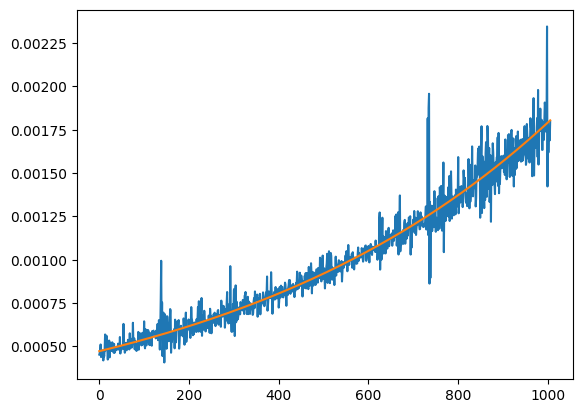

In [6]:
# Suppose we think S&P 500 will deliver 2% and GLD 5% annualized return
mean_views_1 = {"SPY": 0.02/ANNUALIZATION_FACTOR, 'GLD':0.05/ANNUALIZATION_FACTOR}

fv = FlexibleViewsProcessor(
    prior_returns=weekly_returns,
    prior_probabilities=p_exp,
    mean_views=mean_views_1
)

q = fv.get_posterior_probabilities()
print('Prior Effective number of scenarios:',probabilities.compute_effective_number_scenarios(p_exp))
print('Posterior Effective number of scenarios:',probabilities.compute_effective_number_scenarios(q))
plt.plot(q); plt.plot(p_exp); plt.show()

In [7]:
projected_scenarios_compound = project_scenarios(R=weekly_returns,investment_horizon=INVESTMENT_HORIZON,p=q.flatten()/q.sum())
projected_scenarios_simple = convert_scenarios_compound_to_simple(projected_scenarios_compound)

cvar_wrapper = PortfolioWrapper(AssetsDistribution(scenarios=projected_scenarios_simple))

# Set constraints
cvar_wrapper.set_constraints({'long_only': True, 'total_weight': 1.0})
cvar_frontier = cvar_wrapper.mean_cvar_frontier(num_portfolios=20, alpha=0.01)
w_cvar_return_target, r_cvar_return_target, cvar_return_target = cvar_frontier.portfolio_at_return_target(min_return=TARGET_RETURN_HORIZON)
print_portfolio(f"CVaR Portfolio with Return >= {TARGET_RETURN_HORIZON}", 
                w_cvar_return_target, cvar_return_target, cvar_return_target, cvar_frontier.risk_measure)


[pyvallocation.portfolioapi - INFO] No probabilities provided for scenarios. Assuming a uniform distribution.
[pyvallocation.portfolioapi - INFO] PortfolioWrapper initialized for 4 assets.
[pyvallocation.portfolioapi - INFO] Setting constraints with parameters: {'long_only': True, 'total_weight': 1.0}
[pyvallocation.portfolioapi - INFO] Successfully computed Mean-CVaR frontier with 20 portfolios.



--- CVaR Portfolio with Return >= 0.05 ---
  > Expected Return: 0.0488
  > CVaR (alpha=0.01): 0.0488
  > Weights:
DBC    0.000
GLD    0.475
SPY    0.206
TLT    0.319
-------------------------


Prior Effective number of scenarios: 878.1857281784878
Posterior Effective number of scenarios: 788.8592129087081


C:\Users\giulio.cantadori\Repos\Py-vAllocation\pyvallocation\views.py:205: OptimizeWarning: Unknown solver options: maxiter
  solution = minimize(


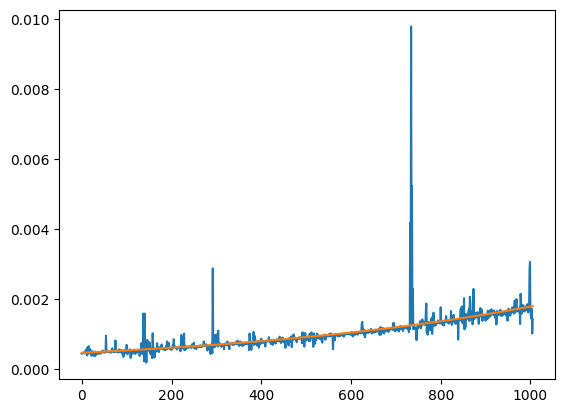

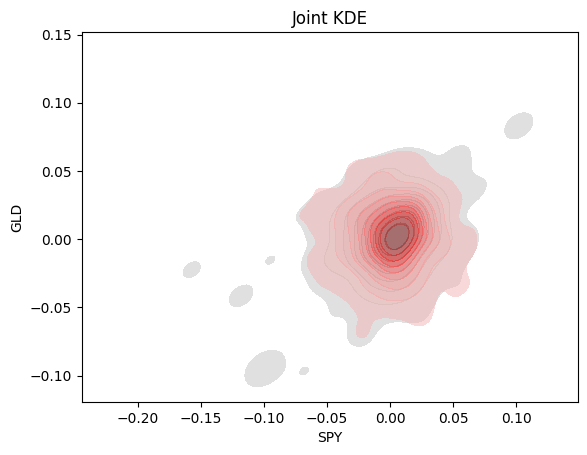

[pyvallocation.portfolioapi - INFO] No probabilities provided for scenarios. Assuming a uniform distribution.
[pyvallocation.portfolioapi - INFO] PortfolioWrapper initialized for 4 assets.
[pyvallocation.portfolioapi - INFO] Setting constraints with parameters: {'long_only': True, 'total_weight': 1.0}
[pyvallocation.portfolioapi - INFO] Successfully computed Mean-CVaR frontier with 20 portfolios.



--- CVaR Portfolio with Return >= 0.05 ---
  > Expected Return: 0.0448
  > CVaR (alpha=0.01): 0.0448
  > Weights:
DBC    0.000
GLD    0.683
SPY    0.115
TLT    0.201
-------------------------


In [8]:
# Suppose we think SPY will have a >50% correlation with GLD and SPY will have a negative return
mean_views_2 = {'SPY':('<',0)}
corr_views = {('SPY','GLD'):('>',.5)}

q = FlexibleViewsProcessor(
    prior_returns=weekly_returns,
    prior_probabilities=p_exp,
    mean_views=mean_views_2,
    corr_views=corr_views
).get_posterior_probabilities()
print('Prior Effective number of scenarios:',probabilities.compute_effective_number_scenarios(p_exp))
print('Posterior Effective number of scenarios:',probabilities.compute_effective_number_scenarios(q))
plt.plot(q); plt.plot(p_exp); plt.show()

sns.kdeplot(x=weekly_returns['SPY'], y=weekly_returns['GLD'], weights=q.flatten(), fill=True, alpha=0.5, color='black')

sns.kdeplot(x=weekly_returns['SPY'], y=weekly_returns['GLD'], weights=p_exp,
            fill=True, alpha=0.5, color='red')

plt.xlabel("SPY"); plt.ylabel("GLD"); plt.title("Joint KDE"); plt.show()

projected_scenarios_compound = project_scenarios(R=weekly_returns,investment_horizon=INVESTMENT_HORIZON,p=q.flatten())
projected_scenarios_simple = convert_scenarios_compound_to_simple(projected_scenarios_compound)

cvar_wrapper = PortfolioWrapper(AssetsDistribution(scenarios=projected_scenarios_simple))

# Set constraints
cvar_wrapper.set_constraints({'long_only': True, 'total_weight': 1.0})
cvar_frontier = cvar_wrapper.mean_cvar_frontier(num_portfolios=20, alpha=0.01)
w_cvar_return_target, r_cvar_return_target, cvar_return_target = cvar_frontier.portfolio_at_return_target(min_return=TARGET_RETURN_HORIZON)
print_portfolio(f"CVaR Portfolio with Return >= {TARGET_RETURN_HORIZON}", 
                w_cvar_return_target, cvar_return_target, cvar_return_target, cvar_frontier.risk_measure)


## Opinion pooling

C:\Users\giulio.cantadori\Repos\Py-vAllocation\pyvallocation\views.py:205: OptimizeWarning: Unknown solver options: maxiter
  solution = minimize(


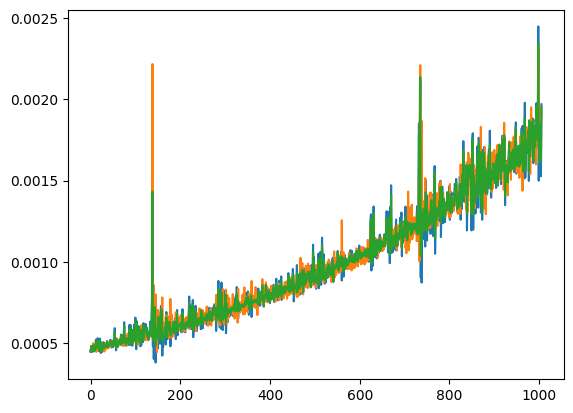

In [9]:
# If we have multiple conflicting views we can leverage the simple opinion pooling

# first view --> SPY returns will be negative
q1 = FlexibleViewsProcessor(
    prior_returns=weekly_returns,
    prior_probabilities=p_exp,
    mean_views={'SPY':('<',0)},
).get_posterior_probabilities()

# second view --> SPY returns will be positive, SPY annualized vol will be >20%
q2 = FlexibleViewsProcessor(
    prior_returns=weekly_returns,
    prior_probabilities=p_exp,
    mean_views={'SPY':('>',0),'TLT':-0.05/ANNUALIZATION_FACTOR},
    vol_views={'SPY':('>',0.2/(ANNUALIZATION_FACTOR**.5))}
).get_posterior_probabilities()

# final probability vector, assigning 75% confidence to the first and 25% to the second view
q_ = q1*.75 + q2*.25

plt.plot(q1);plt.plot(q2);plt.plot(q_)